In [226]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [227]:
# Load data
order_items = pd.read_csv(r"C:\Users\nandana\Desktop\demand_pricing\olist_order_items_dataset.csv\olist_order_items_dataset.csv")

products = pd.read_csv(r"C:\Users\nandana\Desktop\demand_pricing\olist_products_dataset.csv\olist_products_dataset.csv")

orders = pd.read_csv(r"C:\Users\nandana\Desktop\demand_pricing\olist_orders_dataset.csv\olist_orders_dataset.csv")


In [398]:
# Merge order_items with orders to get order date
merged = pd.merge(order_items, orders[['order_id', 'order_purchase_timestamp']],
                  on='order_id', how='left')

# Merge with product info
data = pd.merge(merged, products[['product_id', 'product_category_name']],
                on='product_id', how='left')  # ✅ No comma here

# Convert to datetime
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])

In [399]:
# Extract year and month
data['year'] = data['order_purchase_timestamp'].dt.year
data['month'] = data['order_purchase_timestamp'].dt.month

# Effective price = price + freight
data['effective_price'] = data['price'] + data['freight_value']

# Create cyclical features
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

In [230]:
df = data

In [231]:
df.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'order_purchase_timestamp', 'product_category_name', 'year', 'month',
       'effective_price', 'month_sin', 'month_cos'],
      dtype='object')

In [232]:
df.shape

(112650, 14)

In [233]:
# Check unique values and missing count
print(df['product_category_name'].isnull().sum())
print(df['product_category_name'].unique())

1603
['cool_stuff' 'pet_shop' 'moveis_decoracao' 'perfumaria'
 'ferramentas_jardim' 'utilidades_domesticas' 'telefonia' 'beleza_saude'
 'livros_tecnicos' 'fashion_bolsas_e_acessorios' 'cama_mesa_banho'
 'esporte_lazer' 'consoles_games' 'moveis_escritorio' 'malas_acessorios'
 'alimentos' 'agro_industria_e_comercio' 'eletronicos'
 'informatica_acessorios' 'construcao_ferramentas_construcao' 'audio'
 'bebes' 'construcao_ferramentas_iluminacao' 'brinquedos' 'papelaria'
 'industria_comercio_e_negocios' 'relogios_presentes' 'automotivo' nan
 'eletrodomesticos' 'moveis_cozinha_area_de_servico_jantar_e_jardim'
 'climatizacao' 'casa_conforto' 'telefonia_fixa'
 'portateis_casa_forno_e_cafe' 'fraldas_higiene' 'sinalizacao_e_seguranca'
 'instrumentos_musicais' 'eletroportateis' 'construcao_ferramentas_jardim'
 'artes' 'casa_construcao' 'livros_interesse_geral' 'artigos_de_festas'
 'construcao_ferramentas_seguranca' 'cine_foto'
 'fashion_underwear_e_moda_praia' 'fashion_roupa_masculina'
 'alimentos

In [234]:
# Previous month's quantity sold
df['lag_quantity'] = df.groupby('product_id')['order_item_id'].shift(1)
# Previous month's average price
df['lag_price'] = df.groupby('product_id')['price'].shift(1)

In [235]:
category_agg = df.groupby('product_category_name').agg({
    'freight_value': 'mean',
    'price': 'mean'
}).rename(columns={
    'freight_value': 'avg_freight_per_category',
    'price': 'avg_price_per_category'
})

df = df.merge(category_agg, on='product_category_name', how='left')


In [236]:
df['day'] = pd.to_datetime(df['order_purchase_timestamp']).dt.day
df['day_of_week'] = pd.to_datetime(df['order_purchase_timestamp']).dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)


In [237]:
# Seller reliability
seller_stats = df.groupby('seller_id').agg({
    'price': 'mean',
    'freight_value': 'mean'
}).rename(columns={
    'price': 'avg_price_per_seller',
    'freight_value': 'avg_freight_per_seller'
})

df = df.merge(seller_stats, on='seller_id', how='left')


In [238]:
df.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'order_purchase_timestamp', 'product_category_name', 'year', 'month',
       'effective_price', 'month_sin', 'month_cos', 'lag_quantity',
       'lag_price', 'avg_freight_per_category', 'avg_price_per_category',
       'day', 'day_of_week', 'is_weekend', 'avg_price_per_seller',
       'avg_freight_per_seller'],
      dtype='object')

In [239]:
df.shape

(112650, 23)

In [240]:
# Check total missing values per column
df.isnull().sum()

order_id                        0
order_item_id                   0
product_id                      0
seller_id                       0
shipping_limit_date             0
price                           0
freight_value                   0
order_purchase_timestamp        0
product_category_name        1603
year                            0
month                           0
effective_price                 0
month_sin                       0
month_cos                       0
lag_quantity                32951
lag_price                   32951
avg_freight_per_category     1603
avg_price_per_category       1603
day                             0
day_of_week                     0
is_weekend                      0
avg_price_per_seller            0
avg_freight_per_seller          0
dtype: int64

In [241]:
# Replace missing values

# For categorical column, use mode
df['product_category_name'].fillna(df['product_category_name'].mode()[0], inplace=True)

# For lag and average columns, use median (safer than mean for skewed data)
df['lag_quantity'].fillna(df['lag_quantity'].median(), inplace=True)
df['lag_price'].fillna(df['lag_price'].median(), inplace=True)
df['avg_freight_per_category'].fillna(df['avg_freight_per_category'].median(), inplace=True)
df['avg_price_per_category'].fillna(df['avg_price_per_category'].median(), inplace=True)

In [242]:
# Rank categories based on average price
df['category_price_rank'] = df['avg_price_per_category'].rank(method='dense', ascending=True).astype(int)

# Rank sellers based on average freight
df['seller_freight_rank'] = df['avg_freight_per_seller'].rank(method='dense', ascending=True).astype(int)

In [243]:
df['product_price_std'] = df.groupby('product_id')['price'].transform('std')

In [244]:
df['product_avg_price'] = df.groupby('product_id')['price'].transform('mean')

In [245]:
product_order_counts = df.groupby('product_id')['order_id'].nunique()
df['product_total_orders'] = df['product_id'].map(product_order_counts)

In [246]:
seller_order_counts = df.groupby('seller_id')['order_id'].nunique()
df['seller_total_orders'] = df['seller_id'].map(seller_order_counts)

In [247]:
# Aggregate total quantity sold per product per year-month
total_quantity_df = df.groupby(['product_id', 'year', 'month']).agg(
    total_quantity_sold=('order_item_id', 'count')  # counting items sold
).reset_index()

# Merge this back to your main dataframe (if needed)
df = df.merge(total_quantity_df, on=['product_id', 'year', 'month'], how='left')

# Now you have 'total_quantity_sold' in df, ready for modelin

In [248]:
df.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'order_purchase_timestamp', 'product_category_name', 'year', 'month',
       'effective_price', 'month_sin', 'month_cos', 'lag_quantity',
       'lag_price', 'avg_freight_per_category', 'avg_price_per_category',
       'day', 'day_of_week', 'is_weekend', 'avg_price_per_seller',
       'avg_freight_per_seller', 'category_price_rank', 'seller_freight_rank',
       'product_price_std', 'product_avg_price', 'product_total_orders',
       'seller_total_orders', 'total_quantity_sold'],
      dtype='object')

In [249]:
df.isnull().sum()

order_id                        0
order_item_id                   0
product_id                      0
seller_id                       0
shipping_limit_date             0
price                           0
freight_value                   0
order_purchase_timestamp        0
product_category_name           0
year                            0
month                           0
effective_price                 0
month_sin                       0
month_cos                       0
lag_quantity                    0
lag_price                       0
avg_freight_per_category        0
avg_price_per_category          0
day                             0
day_of_week                     0
is_weekend                      0
avg_price_per_seller            0
avg_freight_per_seller          0
category_price_rank             0
seller_freight_rank             0
product_price_std           18117
product_avg_price               0
product_total_orders            0
seller_total_orders             0
total_quantity

In [250]:
overall_std = df['price'].std()
df['product_price_std'].fillna(overall_std, inplace=True)

In [251]:
df.shape

(112650, 30)

In [252]:
df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_timestamp,product_category_name,year,...,is_weekend,avg_price_per_seller,avg_freight_per_seller,category_price_rank,seller_freight_rank,product_price_std,product_avg_price,product_total_orders,seller_total_orders,total_quantity_sold
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-13 08:59:02,cool_stuff,2017,...,0,81.269603,19.284305,60,1563,3.500000,59.233333,9,138,1
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04-26 10:53:06,pet_shop,2017,...,0,64.185385,20.234196,34,1703,183.633928,239.900000,1,122,1
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:33:31,moveis_decoracao,2018,...,1,234.285714,19.210714,21,1547,0.000000,199.000000,3,12,2
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:00:35,perfumaria,2018,...,0,65.926250,17.315625,40,1189,0.000000,12.990000,2,13,2
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02-04 13:57:51,ferramentas_jardim,2017,...,1,126.247586,20.901724,35,1794,4.522670,202.400000,12,28,1


In [253]:
df.describe()

,order_item_id,price,freight_value,order_purchase_timestamp,year,month,effective_price,month_sin,month_cos,lag_quantity,...,is_weekend,avg_price_per_seller,avg_freight_per_seller,category_price_rank,seller_freight_rank,product_price_std,product_avg_price,product_total_orders,seller_total_orders,total_quantity_sold
count,112650.000000,112650.000000,112650.000000,112650,112650.000000,112650.000000,112650.000000,1.126500e+05,112650.000000,112650.000000,...,112650.000000,112650.000000,112650.000000,112650.000000,112650.000000,112650.000000,112650.000000,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320,2018-01-01 00:09:48.464376576,2017.541909,6.026835,140.644059,7.958487e-02,-0.116889,1.144971,...,0.227111,120.653739,19.990320,36.302361,1305.878518,34.130798,120.653739,32.167545,374.260852,6.097186
min,1.000000,0.850000,0.000000,2016-09-04 21:15:19,2016.000000,1.000000,6.080000,-1.000000e+00,-1.000000,1.000000,...,0.000000,3.500000,1.200000,1.000000,1.000000,0.000000,0.850000,1.000000,1.000000,1.000000
25%,1.000000,39.900000,13.080000,2017-09-13 19:17:04,2017.000000,3.000000,55.220000,-5.000000e-01,-0.866025,1.000000,...,0.000000,56.964103,14.992000,26.000000,725.000000,0.000000,39.900000,2.000000,50.000000,1.000000
50%,1.000000,74.990000,16.260000,2018-01-19 23:02:16,2018.000000,6.000000,92.320000,1.224647e-16,-0.500000,1.000000,...,0.000000,91.728555,17.648234,36.000000,1252.000000,3.217336,74.929412,6.000000,151.000000,2.000000
75%,1.000000,134.900000,21.150000,2018-05-04 17:30:36.750000128,2018.000000,8.000000,157.937500,8.660254e-01,0.500000,1.000000,...,0.000000,134.961250,21.076277,43.000000,1814.000000,13.807113,135.561250,24.000000,473.000000,5.000000
max,21.000000,6735.000000,409.680000,2018-09-03 09:06:57,2018.000000,12.000000,6929.310000,1.000000e+00,1.000000,20.000000,...,1.000000,6729.000000,308.336667,73.000000,2868.000000,706.470385,6735.000000,467.000000,1854.000000,122.000000
std,0.705124,183.633928,15.806405,NaN,0.504792,3.232541,190.724394,6.943481e-01,0.705615,0.616995,...,0.418966,137.731003,9.953954,14.970464,681.333041,66.558370,183.269636,70.038021,490.294546,11.980660


In [254]:
df.duplicated().sum()

0

In [255]:
# Loop through each numeric column and calculate statistics

# Select numeric columns excluding 'employee_id'
numeric_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns=['employee_id'], errors='ignore')

for col in numeric_cols.select_dtypes(include=['int64', 'float64']).columns:
    print(f"Column: {col}")
    print(f"Mean: {df[col].mean()}")
    print(f"Median: {df[col].median()}")
    print(f"Mode: {df[col].mode()[0]}")  # Mode can have multiple values, selecting the first one
    print(f"Standard Deviation: {df[col].std()}")
    print(f"Variance: {df[col].var()}")
    print(f"Skewness: {df[col].skew()}")
    print(f"Kurtosis: {df[col].kurt()}")
    print("-" * 40)  # Separator for readability

Column: order_item_id
Mean: 1.1978339991122948
Median: 1.0
Mode: 1
Standard Deviation: 0.7051240313956294
Variance: 0.4971998996516246
Skewness: 7.580355726011262
Kurtosis: 103.85736059917143
----------------------------------------
Column: price
Mean: 120.65373901464716
Median: 74.99
Mode: 59.9
Standard Deviation: 183.63392805025404
Variance: 33721.41953116588
Skewness: 7.92320826321351
Kurtosis: 120.82829811136266
----------------------------------------
Column: freight_value
Mean: 19.990319928983578
Median: 16.26
Mode: 15.1
Standard Deviation: 15.806405412296854
Variance: 249.84245205788727
Skewness: 5.639869620428684
Kurtosis: 59.78825261835198
----------------------------------------
Column: effective_price
Mean: 140.6440589436307
Median: 92.32000000000001
Mode: 77.57
Standard Deviation: 190.72439403174047
Variance: 36375.7944787746
Skewness: 7.686087336732366
Kurtosis: 115.00757978034277
----------------------------------------
Column: month_sin
Mean: 0.07958487314540832
Median: 

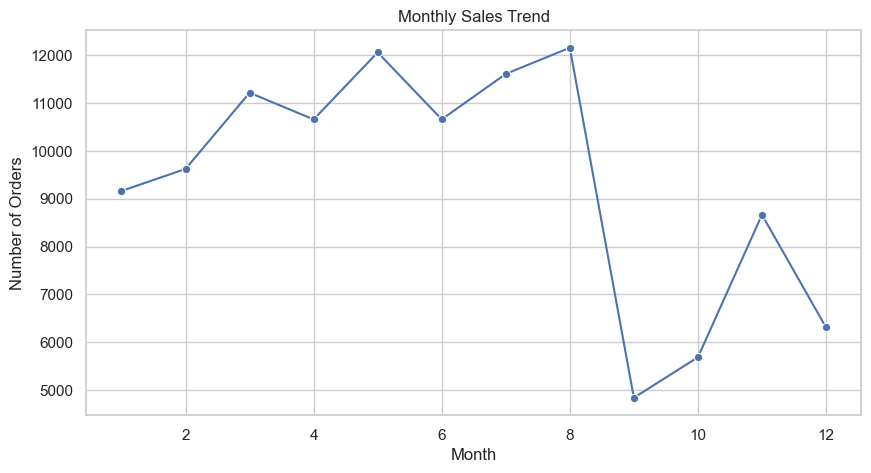

In [256]:
import seaborn as sns
import matplotlib.pyplot as plt

monthly_sales = df.groupby('month')['order_id'].count().reset_index()
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_sales, x='month', y='order_id', marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

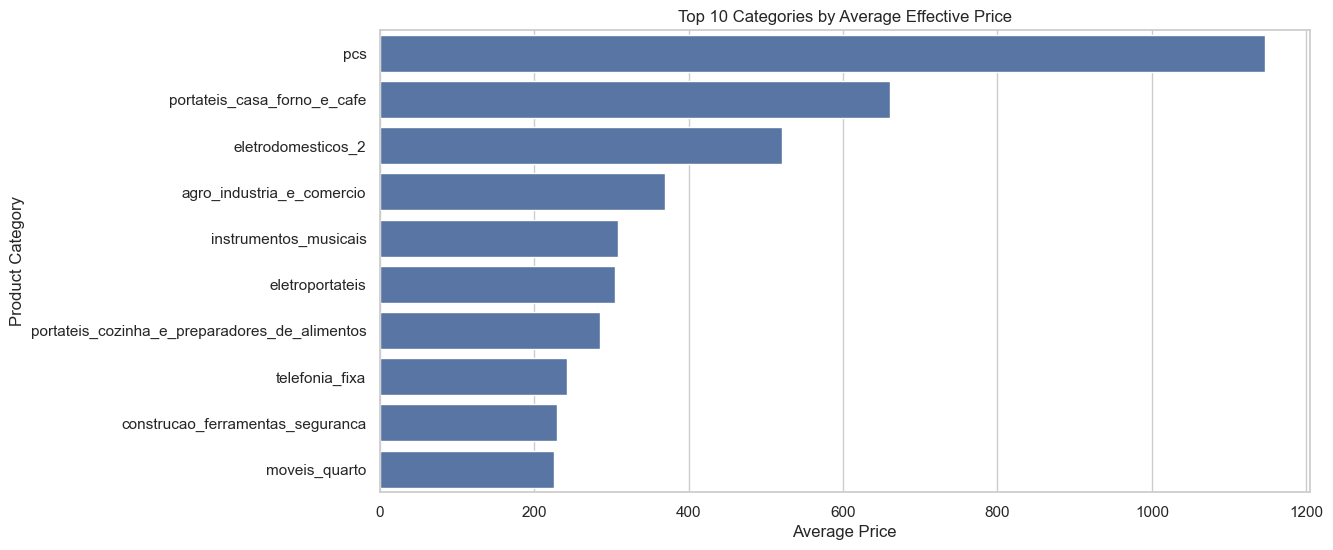

In [257]:
category_price = df.groupby('product_category_name')['effective_price'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=category_price.values, y=category_price.index)
plt.title('Top 10 Categories by Average Effective Price')
plt.xlabel('Average Price')
plt.ylabel('Product Category')
plt.show()

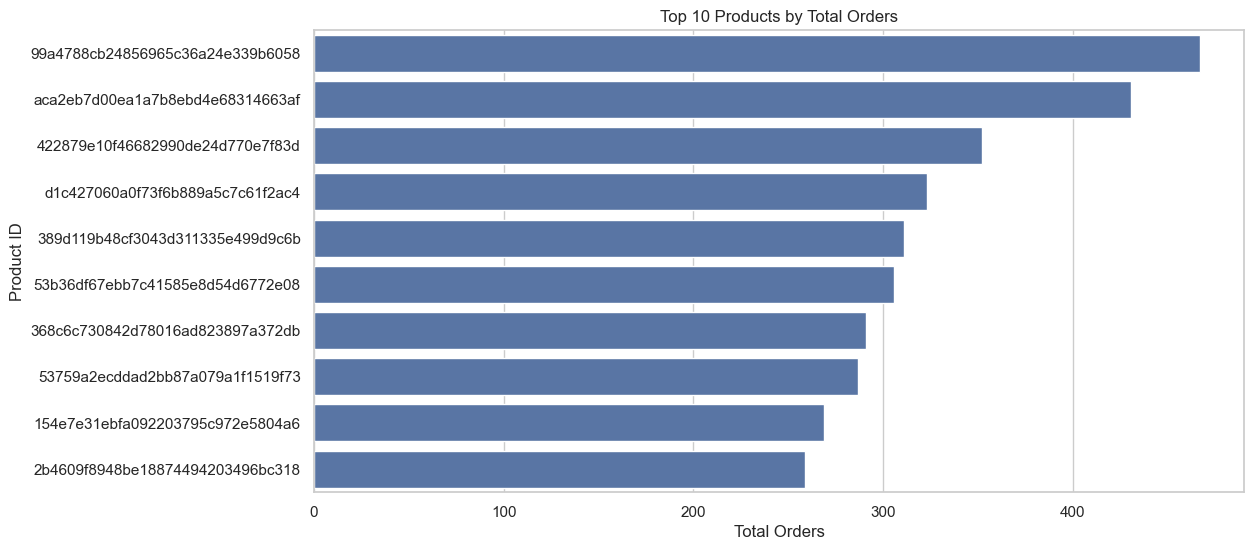

In [258]:
top_products = df.groupby('product_id')['product_total_orders'].max().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 Products by Total Orders')
plt.xlabel('Total Orders')
plt.ylabel('Product ID')
plt.show()

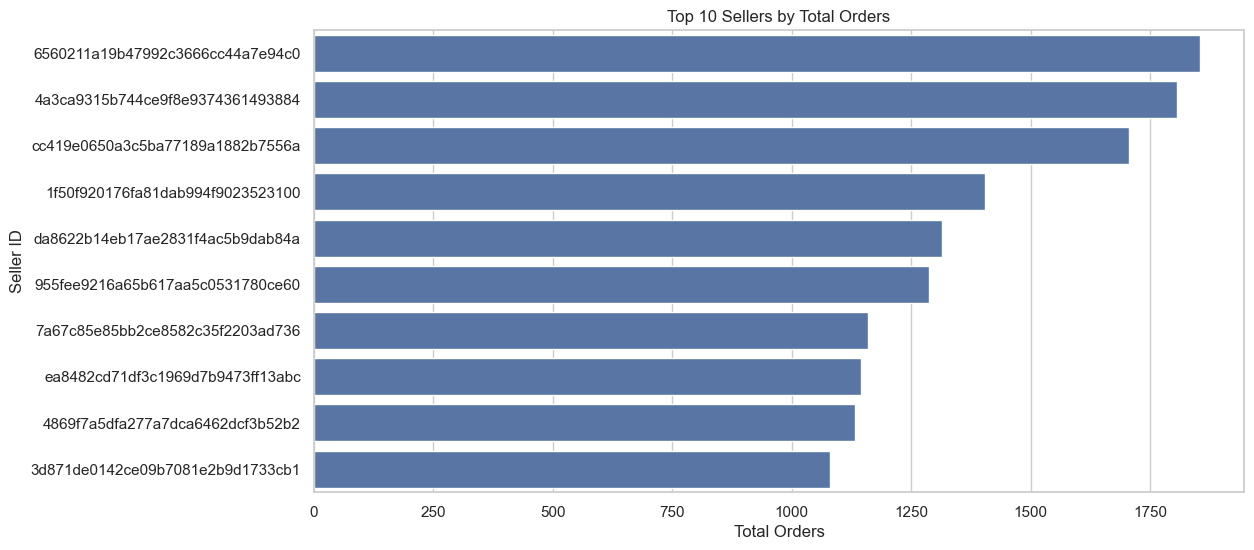

In [259]:
top_sellers = df.groupby('seller_id')['seller_total_orders'].max().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_sellers.values, y=top_sellers.index)
plt.title('Top 10 Sellers by Total Orders')
plt.xlabel('Total Orders')
plt.ylabel('Seller ID')
plt.show()

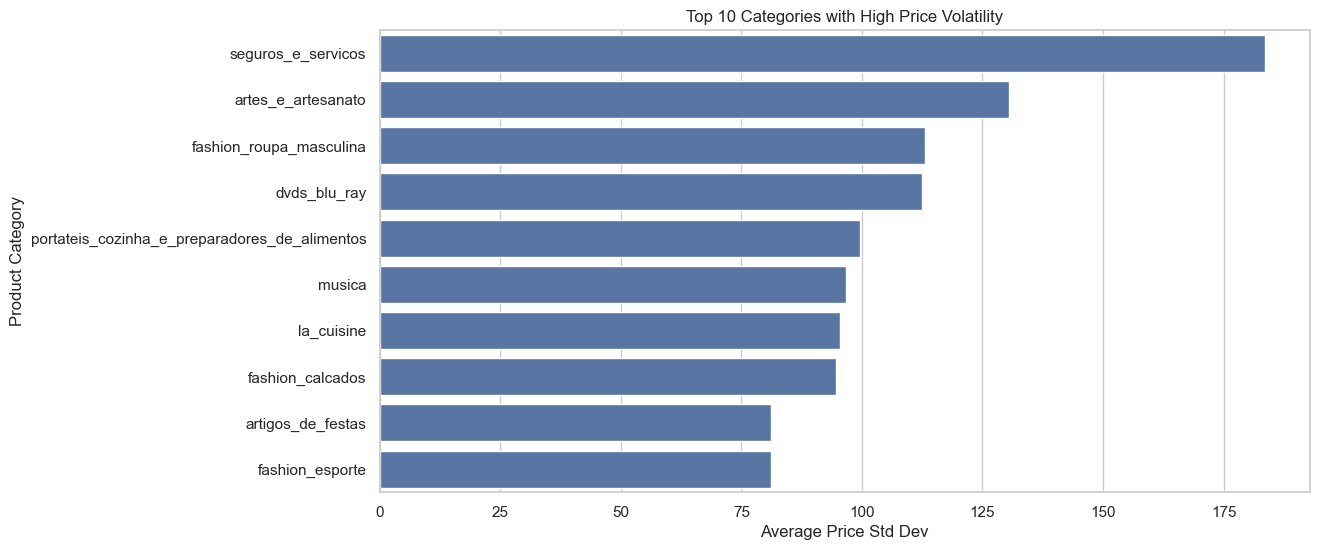

In [260]:
price_volatility = df.groupby('product_category_name')['product_price_std'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=price_volatility.values, y=price_volatility.index)
plt.title('Top 10 Categories with High Price Volatility')
plt.xlabel('Average Price Std Dev')
plt.ylabel('Product Category')
plt.show()

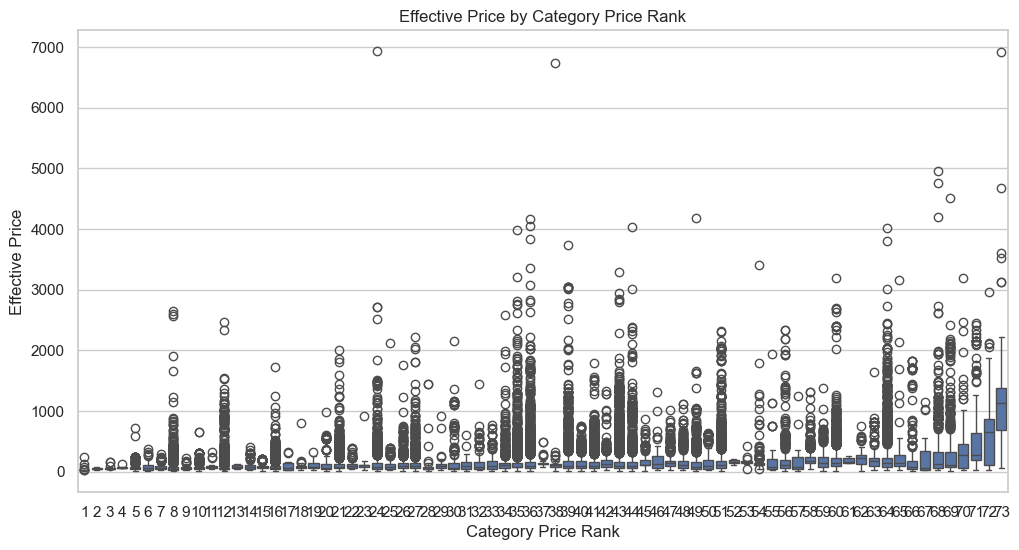

In [261]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='category_price_rank', y='effective_price')
plt.title('Effective Price by Category Price Rank')
plt.xlabel('Category Price Rank')
plt.ylabel('Effective Price')
plt.show()

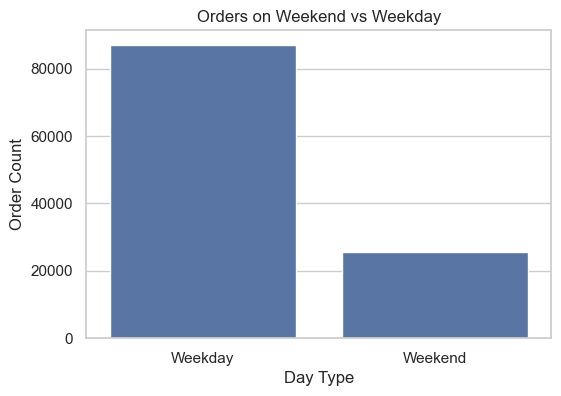

In [262]:
weekend_orders = df.groupby('is_weekend')['order_id'].count().reset_index()
weekend_orders['Day Type'] = weekend_orders['is_weekend'].map({0: 'Weekday', 1: 'Weekend'})
plt.figure(figsize=(6, 4))
sns.barplot(data=weekend_orders, x='Day Type', y='order_id')
plt.title('Orders on Weekend vs Weekday')
plt.ylabel('Order Count')
plt.show()


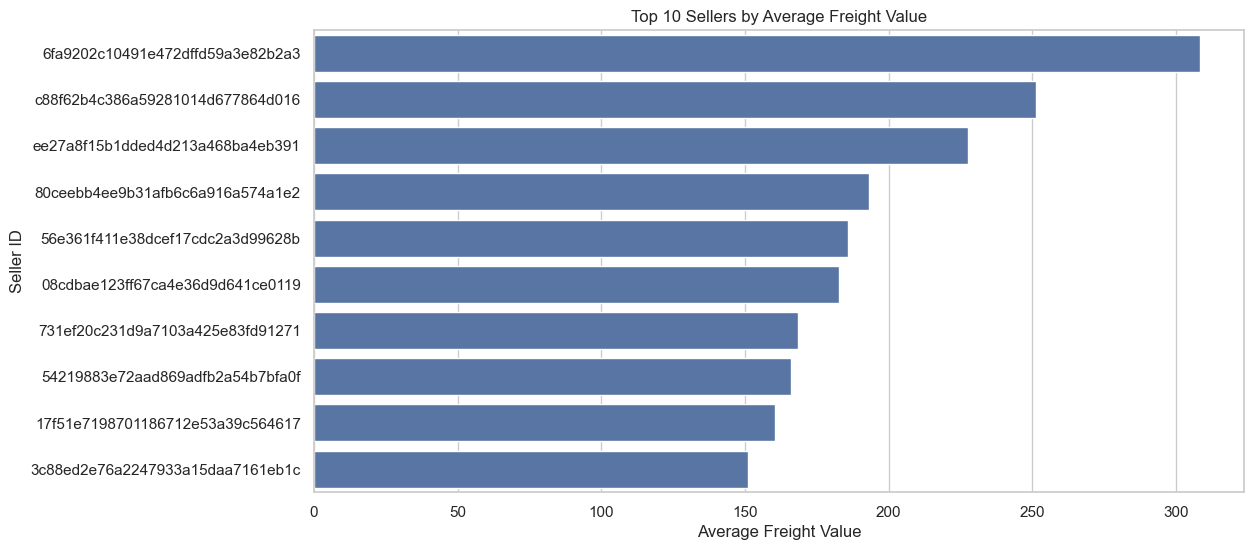

In [263]:
freight_top_sellers = df.groupby('seller_id')['avg_freight_per_seller'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=freight_top_sellers.values, y=freight_top_sellers.index)
plt.title('Top 10 Sellers by Average Freight Value')
plt.xlabel('Average Freight Value')
plt.ylabel('Seller ID')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

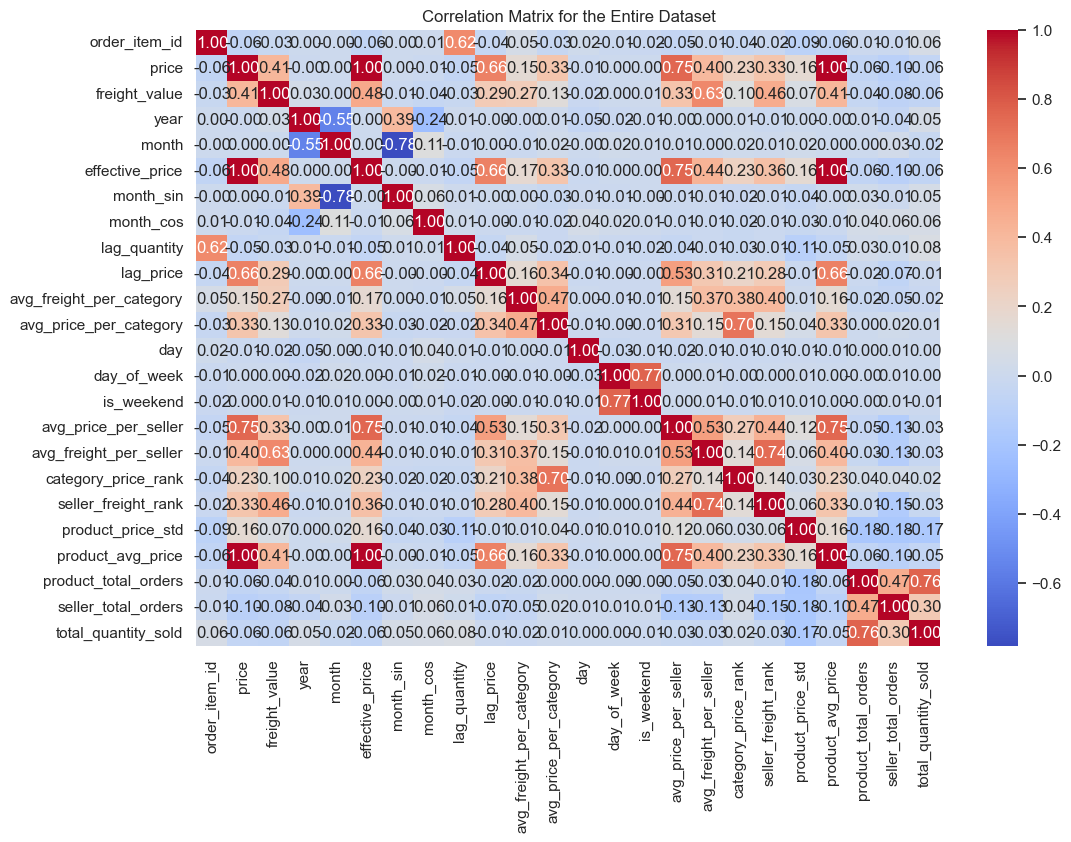

In [264]:
# identify non-numeric column
non_numeric_columns = df.select_dtypes(exclude=['number']).columns

#remove non_numeric columns or convert them to numeric if possible
df_numeric = df.drop(columns=non_numeric_columns)

#compute correlation matrix for the cleaned dataset
corr_matrix = df_numeric.corr()

# plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',fmt=".2f")
plt.title("Correlation Matrix for the Entire Dataset")
plt.show

In [265]:
df.drop(columns=[
    'order_id',
    'order_item_id',
    'shipping_limit_date',
    'order_purchase_timestamp',
    'product_id',
    'seller_id',
], inplace=True)

In [266]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   price                     112650 non-null  float64
 1   freight_value             112650 non-null  float64
 2   product_category_name     112650 non-null  object 
 3   year                      112650 non-null  int32  
 4   month                     112650 non-null  int32  
 5   effective_price           112650 non-null  float64
 6   month_sin                 112650 non-null  float64
 7   month_cos                 112650 non-null  float64
 8   lag_quantity              112650 non-null  float64
 9   lag_price                 112650 non-null  float64
 10  avg_freight_per_category  112650 non-null  float64
 11  avg_price_per_category    112650 non-null  float64
 12  day                       112650 non-null  int32  
 13  day_of_week               112650 non-null  i

In [267]:
# ✅ Get numerical columns
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()

# ✅ Display them
print("Numerical columns:")
for col in numerical_columns:
    print(f"- {col}")

Numerical columns:
- price
- freight_value
- year
- month
- effective_price
- month_sin
- month_cos
- lag_quantity
- lag_price
- avg_freight_per_category
- avg_price_per_category
- day
- day_of_week
- is_weekend
- avg_price_per_seller
- avg_freight_per_seller
- category_price_rank
- seller_freight_rank
- product_price_std
- product_avg_price
- product_total_orders
- seller_total_orders
- total_quantity_sold


In [268]:
# ✅ List of numerical columns to check for outliers
columns_to_check = [
    'price', 'freight_value', 'year', 'month', 'effective_price', 'month_sin', 'month_cos',
    'lag_quantity', 'lag_price', 'avg_freight_per_category', 'avg_price_per_category', 'day',
    'day_of_week', 'is_weekend', 'avg_price_per_seller', 'avg_freight_per_seller',
    'category_price_rank', 'seller_freight_rank', 'product_price_std', 'product_avg_price',
    'product_total_orders', 'seller_total_orders','total_quantity_sold'
]

# ✅ Function to detect outliers using IQR for selected columns
def detect_outliers_iqr(data, columns):
    outlier_counts = {}  # Store outlier counts

    for column in columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Find outliers
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        outlier_counts[column] = outliers.shape[0]  # Count of outliers

    return outlier_counts

# ✅ Apply the function to your DataFrame (replace 'df' with your actual variable name if different)
outliers_iqr = detect_outliers_iqr(df, columns_to_check)

# ✅ Display the results
print("\nOutliers detected in each numerical column using IQR method:")
for col, count in outliers_iqr.items():
    print(f"{col}: {count} outliers")


Outliers detected in each numerical column using IQR method:
price: 8427 outliers
freight_value: 12134 outliers
year: 0 outliers
month: 0 outliers
effective_price: 8253 outliers
month_sin: 0 outliers
month_cos: 0 outliers
lag_quantity: 10134 outliers
lag_price: 11453 outliers
avg_freight_per_category: 6550 outliers
avg_price_per_category: 8615 outliers
day: 0 outliers
day_of_week: 0 outliers
is_weekend: 25584 outliers
avg_price_per_seller: 8186 outliers
avg_freight_per_seller: 9380 outliers
category_price_rank: 1409 outliers
seller_freight_rank: 0 outliers
product_price_std: 19978 outliers
product_avg_price: 8245 outliers
product_total_orders: 15251 outliers
seller_total_orders: 14306 outliers
total_quantity_sold: 13954 outliers


In [269]:
def cap_outliers_iqr(data, columns):
    df_capped = data.copy()
    
    for col in columns:
        Q1 = df_capped[col].quantile(0.25)
        Q3 = df_capped[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Replace values below lower bound with lower bound
        df_capped.loc[df_capped[col] < lower_bound, col] = lower_bound
        
        # Replace values above upper bound with upper bound
        df_capped.loc[df_capped[col] > upper_bound, col] = upper_bound
        
    return df_capped

# List of numerical columns (as before)
columns_to_check = [
    'price', 'freight_value', 'year', 'month', 'effective_price', 'month_sin', 'month_cos',
    'lag_quantity', 'lag_price', 'avg_freight_per_category', 'avg_price_per_category', 'day',
    'day_of_week', 'is_weekend', 'avg_price_per_seller', 'avg_freight_per_seller',
    'category_price_rank', 'seller_freight_rank', 'product_price_std', 'product_avg_price',
    'product_total_orders', 'seller_total_orders','total_quantity_sold'
]

# Apply capping
df= cap_outliers_iqr(df, columns_to_check)

print("Outliers capped successfully.")

Outliers capped successfully.


In [270]:
# ✅ List of numerical columns to check for outliers
columns_to_check = [
    'price', 'freight_value', 'year', 'month', 'effective_price', 'month_sin', 'month_cos',
    'lag_quantity', 'lag_price', 'avg_freight_per_category', 'avg_price_per_category', 'day',
    'day_of_week', 'is_weekend', 'avg_price_per_seller', 'avg_freight_per_seller',
    'category_price_rank', 'seller_freight_rank', 'product_price_std', 'product_avg_price',
    'product_total_orders', 'seller_total_orders','total_quantity_sold'
]

# ✅ Function to detect outliers using IQR for selected columns
def detect_outliers_iqr(data, columns):
    outlier_counts = {}  # Store outlier counts

    for column in columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Find outliers
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        outlier_counts[column] = outliers.shape[0]  # Count of outliers

    return outlier_counts

# ✅ Apply the function to your DataFrame (replace 'df' with your actual variable name if different)
outliers_iqr = detect_outliers_iqr(df, columns_to_check)

# ✅ Display the results
print("\nOutliers detected in each numerical column using IQR method:")
for col, count in outliers_iqr.items():
    print(f"{col}: {count} outliers")


Outliers detected in each numerical column using IQR method:
price: 0 outliers
freight_value: 0 outliers
year: 0 outliers
month: 0 outliers
effective_price: 0 outliers
month_sin: 0 outliers
month_cos: 0 outliers
lag_quantity: 0 outliers
lag_price: 0 outliers
avg_freight_per_category: 0 outliers
avg_price_per_category: 0 outliers
day: 0 outliers
day_of_week: 0 outliers
is_weekend: 0 outliers
avg_price_per_seller: 0 outliers
avg_freight_per_seller: 0 outliers
category_price_rank: 0 outliers
seller_freight_rank: 0 outliers
product_price_std: 0 outliers
product_avg_price: 0 outliers
product_total_orders: 0 outliers
seller_total_orders: 0 outliers
total_quantity_sold: 0 outliers


In [271]:
# import libraries
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

In [272]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

print("RobustScaler applied to numerical columns.")

RobustScaler applied to numerical columns.


In [273]:
# ✅ List of numerical columns to check for outliers
columns_to_check = [
    'price', 'freight_value', 'year', 'month', 'effective_price', 'month_sin', 'month_cos',
    'lag_quantity', 'lag_price', 'avg_freight_per_category', 'avg_price_per_category', 'day',
    'day_of_week', 'is_weekend', 'avg_price_per_seller', 'avg_freight_per_seller',
    'category_price_rank', 'seller_freight_rank', 'product_price_std', 'product_avg_price',
    'product_total_orders', 'seller_total_orders'
]

# ✅ Function to detect outliers using IQR for selected columns
def detect_outliers_iqr(data, columns):
    outlier_counts = {}  # Store outlier counts

    for column in columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Find outliers
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        outlier_counts[column] = outliers.shape[0]  # Count of outliers

    return outlier_counts

# ✅ Apply the function to your DataFrame (replace 'df' with your actual variable name if different)
outliers_iqr = detect_outliers_iqr(df, columns_to_check)

# ✅ Display the results
print("\nOutliers detected in each numerical column using IQR method:")
for col, count in outliers_iqr.items():
    print(f"{col}: {count} outliers")


Outliers detected in each numerical column using IQR method:
price: 0 outliers
freight_value: 0 outliers
year: 0 outliers
month: 0 outliers
effective_price: 8253 outliers
month_sin: 0 outliers
month_cos: 0 outliers
lag_quantity: 0 outliers
lag_price: 11453 outliers
avg_freight_per_category: 0 outliers
avg_price_per_category: 8552 outliers
day: 0 outliers
day_of_week: 0 outliers
is_weekend: 0 outliers
avg_price_per_seller: 0 outliers
avg_freight_per_seller: 0 outliers
category_price_rank: 1409 outliers
seller_freight_rank: 0 outliers
product_price_std: 0 outliers
product_avg_price: 8245 outliers
product_total_orders: 0 outliers
seller_total_orders: 0 outliers


In [274]:
import numpy as np

cols_to_log = ['avg_freight_per_category', 'avg_price_per_category', 'category_price_rank']

for col in cols_to_log:
    df[col] = np.log1p(df[col])  # log1p safely handles zero or very small values

In [275]:
# ✅ List of numerical columns to check for outliers
columns_to_check = [
    'price', 'freight_value', 'year', 'month', 'effective_price', 'month_sin', 'month_cos',
    'lag_quantity', 'lag_price', 'avg_freight_per_category', 'avg_price_per_category', 'day',
    'day_of_week', 'is_weekend', 'avg_price_per_seller', 'avg_freight_per_seller',
    'category_price_rank', 'seller_freight_rank', 'product_price_std', 'product_avg_price',
    'product_total_orders', 'seller_total_orders','total_quantity_sold'
]

# ✅ Function to detect outliers using IQR for selected columns
def detect_outliers_iqr(data, columns):
    outlier_counts = {}  # Store outlier counts

    for column in columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Find outliers
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        outlier_counts[column] = outliers.shape[0]  # Count of outliers

    return outlier_counts

# ✅ Apply the function to your DataFrame (replace 'df' with your actual variable name if different)
outliers_iqr = detect_outliers_iqr(df, columns_to_check)

# ✅ Display the results
print("\nOutliers detected in each numerical column using IQR method:")
for col, count in outliers_iqr.items():
    print(f"{col}: {count} outliers")


Outliers detected in each numerical column using IQR method:
price: 0 outliers
freight_value: 0 outliers
year: 0 outliers
month: 0 outliers
effective_price: 8253 outliers
month_sin: 0 outliers
month_cos: 0 outliers
lag_quantity: 0 outliers
lag_price: 11453 outliers
avg_freight_per_category: 9311 outliers
avg_price_per_category: 60 outliers
day: 0 outliers
day_of_week: 0 outliers
is_weekend: 0 outliers
avg_price_per_seller: 0 outliers
avg_freight_per_seller: 0 outliers
category_price_rank: 685 outliers
seller_freight_rank: 0 outliers
product_price_std: 0 outliers
product_avg_price: 8245 outliers
product_total_orders: 0 outliers
seller_total_orders: 0 outliers
total_quantity_sold: 0 outliers


In [276]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['product_category_encoded'] = le.fit_transform(df['product_category_name'])

print("Label Encoding done.")


Label Encoding done.


In [277]:
df.head()

,price,freight_value,product_category_name,year,month,effective_price,month_sin,month_cos,lag_quantity,lag_price,...,avg_price_per_seller,avg_freight_per_seller,category_price_rank,seller_freight_rank,product_price_std,product_avg_price,product_total_orders,seller_total_orders,total_quantity_sold,product_category_encoded
0,-0.169368,-0.368030,cool_stuff,-1.0,0.6,-0.195974,-0.732051,3.660254e-01,0.0,0.0,...,-0.134094,0.268901,0.880359,0.285583,0.020472,-0.164080,0.136364,-0.030733,-0.25,26
1,1.735895,0.454771,pet_shop,-1.0,-0.4,1.630783,0.633975,0.000000e+00,0.0,0.0,...,-0.353130,0.425024,-0.125163,0.414141,2.266980,1.724529,-0.227273,-0.068558,-0.25,63
2,1.305368,0.199504,moveis_decoracao,0.0,-1.0,1.212549,0.366025,1.000000e+00,0.0,0.0,...,1.827723,0.256806,-2.140066,0.270891,-0.233020,1.296979,-0.136364,-0.328605,0.00,54
3,-0.652632,-0.429988,perfumaria,0.0,0.4,-0.647796,-0.633975,-4.876438e-16,0.0,0.0,...,-0.330811,-0.054667,0.211309,-0.057851,-0.233020,-0.647487,-0.181818,-0.326241,0.00,62
4,1.314842,0.232962,ferramentas_jardim,-1.0,-0.8,1.223939,0.633975,7.320508e-01,0.0,0.0,...,0.442568,0.534737,-0.060625,0.497704,0.094541,1.332521,0.272727,-0.290780,-0.25,40


In [278]:
from sklearn.model_selection import train_test_split

# Features (X) - select the columns you want to use as input
# Example including numerical columns + encoded category
X = df.drop(columns=['total_quantity_sold', 'product_category_name'])  # drop target and IDs

# Target (Y)
Y = df['total_quantity_sold']  # or your target column



In [279]:
X.isnull().sum()

price                           0
freight_value                   0
year                            0
month                           0
effective_price                 0
month_sin                       0
month_cos                       0
lag_quantity                    0
lag_price                       0
avg_freight_per_category    12404
avg_price_per_category      11287
day                             0
day_of_week                     0
is_weekend                      0
avg_price_per_seller            0
avg_freight_per_seller          0
category_price_rank         11347
seller_freight_rank             0
product_price_std               0
product_avg_price               0
product_total_orders            0
seller_total_orders             0
product_category_encoded        0
dtype: int64

In [280]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   price                     112650 non-null  float64
 1   freight_value             112650 non-null  float64
 2   year                      112650 non-null  float64
 3   month                     112650 non-null  float64
 4   effective_price           112650 non-null  float64
 5   month_sin                 112650 non-null  float64
 6   month_cos                 112650 non-null  float64
 7   lag_quantity              112650 non-null  float64
 8   lag_price                 112650 non-null  float64
 9   avg_freight_per_category  100246 non-null  float64
 10  avg_price_per_category    101363 non-null  float64
 11  day                       112650 non-null  float64
 12  day_of_week               112650 non-null  float64
 13  is_weekend                112650 non-null  f

In [281]:
# Split: 80% training, 20% testing (you can adjust test_size)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (90120, 23), Test shape: (22530, 23)


In [282]:
X_train

,price,freight_value,year,month,effective_price,month_sin,month_cos,lag_quantity,lag_price,avg_freight_per_category,...,is_weekend,avg_price_per_seller,avg_freight_per_seller,category_price_rank,seller_freight_rank,product_price_std,product_avg_price,product_total_orders,seller_total_orders,product_category_encoded
86547,0.006421,-0.407683,0.0,-0.6,-0.036508,7.320508e-01,0.366025,0.0,0.074227,0.541834,...,0.0,-0.527501,-0.385059,-2.140066,-0.423324,-0.233020,0.007010,-0.090909,-0.139480,54
7323,-0.158842,0.612144,-1.0,0.6,-0.109232,-7.320508e-01,0.366025,0.0,-0.249485,0.921008,...,0.0,-0.466021,0.092523,-0.060625,0.104683,0.083672,-0.209257,2.318182,2.261229,40
27237,0.315789,0.902107,0.0,0.0,0.352520,0.000000e+00,-0.366025,0.0,0.000000,0.848937,...,0.0,-0.610480,0.312830,-0.268264,0.324151,0.310998,0.382240,-0.090909,-0.163121,24
99544,-0.590421,0.718711,0.0,-0.2,-0.500012,3.660254e-01,-0.267949,0.0,-1.094845,0.598602,...,0.0,-0.578152,-0.522351,-1.223775,-0.590450,-0.157373,-0.596160,0.090909,-0.146572,72
56252,0.092737,0.273854,0.0,-0.2,0.096868,3.660254e-01,-0.267949,0.0,0.243299,0.220084,...,0.0,0.087067,-0.288368,0.000000,-0.326905,-0.233020,0.092729,0.090909,-0.269504,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76820,1.368526,2.105948,-1.0,0.2,1.572760,-3.660254e-01,-0.267949,0.0,2.075258,-0.198971,...,0.0,1.349389,0.657535,-0.753772,0.559229,1.077521,1.252949,2.318182,0.286052,13
110268,0.368526,-1.894052,0.0,-0.4,0.172123,6.339746e-01,0.000000,0.0,1.257732,-1.695061,...,0.0,1.344426,-0.446050,0.973449,-0.495868,1.239257,0.436305,2.318182,0.978723,66
103694,-0.484105,-1.050805,-1.0,0.6,-0.540706,-7.320508e-01,0.366025,0.0,-0.886598,-1.695061,...,0.0,-0.398436,-0.640125,0.973449,-0.709826,-0.233020,-0.480126,2.318182,2.261229,66
860,-0.263579,-0.018587,0.0,-1.0,-0.255653,3.660254e-01,1.000000,0.0,0.000000,-0.198971,...,0.0,-0.340449,-0.168242,-0.753772,-0.175390,-0.233020,-0.261124,0.863636,0.886525,13


In [283]:
import numpy as np

# Replace inf/-inf with NaN (to make detection easier)
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill missing values using median (recommended for regression)
X_train.fillna(X_train.median(), inplace=True)
X_test.fillna(X_test.median(), inplace=True)

In [284]:
X_train.reset_index(drop=True, inplace=True)

In [285]:
Y_train.reset_index(drop=True, inplace=True)

In [286]:
X_test.reset_index(drop=True, inplace=True)

In [287]:
Y_test.reset_index(drop=True, inplace=True)

In [288]:
X_train.head()

,price,freight_value,year,month,effective_price,month_sin,month_cos,lag_quantity,lag_price,avg_freight_per_category,...,is_weekend,avg_price_per_seller,avg_freight_per_seller,category_price_rank,seller_freight_rank,product_price_std,product_avg_price,product_total_orders,seller_total_orders,product_category_encoded
0,0.006421,-0.407683,0.0,-0.6,-0.036508,0.732051,0.366025,0.0,0.074227,0.541834,...,0.0,-0.527501,-0.385059,-2.140066,-0.423324,-0.233020,0.007010,-0.090909,-0.139480,54
1,-0.158842,0.612144,-1.0,0.6,-0.109232,-0.732051,0.366025,0.0,-0.249485,0.921008,...,0.0,-0.466021,0.092523,-0.060625,0.104683,0.083672,-0.209257,2.318182,2.261229,40
2,0.315789,0.902107,0.0,0.0,0.352520,0.000000,-0.366025,0.0,0.000000,0.848937,...,0.0,-0.610480,0.312830,-0.268264,0.324151,0.310998,0.382240,-0.090909,-0.163121,24
3,-0.590421,0.718711,0.0,-0.2,-0.500012,0.366025,-0.267949,0.0,-1.094845,0.598602,...,0.0,-0.578152,-0.522351,-1.223775,-0.590450,-0.157373,-0.596160,0.090909,-0.146572,72
4,0.092737,0.273854,0.0,-0.2,0.096868,0.366025,-0.267949,0.0,0.243299,0.220084,...,0.0,0.087067,-0.288368,0.000000,-0.326905,-0.233020,0.092729,0.090909,-0.269504,32


In [289]:
Y_train.head()

0    0.25
1    2.25
2   -0.25
3    2.00
4   -0.25
Name: total_quantity_sold, dtype: float64

In [290]:
X_test.head()

,price,freight_value,year,month,effective_price,month_sin,month_cos,lag_quantity,lag_price,avg_freight_per_category,...,is_weekend,avg_price_per_seller,avg_freight_per_seller,category_price_rank,seller_freight_rank,product_price_std,product_avg_price,product_total_orders,seller_total_orders,product_category_encoded
0,1.105368,0.519207,0.0,0.0,1.052693,0.000000,-0.366025,0.0,1.154639,-1.695061,...,0.0,1.344426,-0.446050,0.973449,-0.495868,2.266980,0.912869,1.545455,0.978723,66
1,-0.673684,-0.026022,-1.0,-0.6,-0.635529,0.732051,0.366025,0.0,0.000000,0.541834,...,0.0,-0.675286,-0.458517,-2.140066,-0.510560,-0.233020,-0.668394,0.000000,-0.144208,54
2,-0.263158,-0.914498,0.0,-0.2,-0.325650,0.366025,-0.267949,0.0,-0.453814,1.199836,...,0.0,-0.480486,0.180171,0.498991,0.196511,-0.229761,-0.260941,-0.090909,-0.160757,57
3,0.445368,-0.226766,-1.0,-0.2,0.383674,0.366025,-0.267949,0.0,0.934021,0.773551,...,0.0,0.737527,0.748875,0.632523,0.614325,-0.233020,0.442923,2.318182,0.557920,8
4,-0.169368,-0.308550,0.0,-0.4,-0.191301,0.633975,0.000000,0.0,0.000000,-0.028932,...,0.0,-0.115114,0.313955,0.257829,0.325987,2.266980,-0.167564,-0.227273,2.196217,12


In [291]:
Y_test.head()

0    2.25
1   -0.25
2   -0.25
3    1.25
4   -0.25
Name: total_quantity_sold, dtype: float64

In [292]:
import numpy as np

# Replace inf/-inf with NaN (to make detection easier)
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill missing values using median (recommended for regression)
X_train.fillna(X_train.median(), inplace=True)
X_test.fillna(X_test.median(), inplace=True)

In [293]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


In [294]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90120 entries, 0 to 90119
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   price                     90120 non-null  float64
 1   freight_value             90120 non-null  float64
 2   year                      90120 non-null  float64
 3   month                     90120 non-null  float64
 4   effective_price           90120 non-null  float64
 5   month_sin                 90120 non-null  float64
 6   month_cos                 90120 non-null  float64
 7   lag_quantity              90120 non-null  float64
 8   lag_price                 90120 non-null  float64
 9   avg_freight_per_category  90120 non-null  float64
 10  avg_price_per_category    90120 non-null  float64
 11  day                       90120 non-null  float64
 12  day_of_week               90120 non-null  float64
 13  is_weekend                90120 non-null  float64
 14  avg_pr

In [295]:
# Initialize and train model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, Y_train)


RandomForestRegressor(random_state=42)

In [296]:
# Predict
Y_pred_rf = rf_model.predict(X_test)

In [297]:
# Metrics
mse_rf = mean_squared_error(Y_test, Y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(Y_test, Y_pred_rf)
r2_rf = r2_score(Y_test, Y_pred_rf)
mape_rf = np.mean(np.abs((Y_test - Y_pred_rf) / Y_test)) * 100

In [298]:
# Display results
print("🔷 RANDOM FOREST RESULTS 🔷")
print(f"R² Score: {r2_rf:.4f}")
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_rf:.2f}%\n")

🔷 RANDOM FOREST RESULTS 🔷
R² Score: 0.9326
Mean Squared Error (MSE): 0.05
Root Mean Squared Error (RMSE): 0.23
Mean Absolute Error (MAE): 0.14
Mean Absolute Percentage Error (MAPE): inf%



In [299]:
from xgboost import XGBRegressor

In [300]:
# Initialize and train model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, Y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [301]:

# Predict
Y_pred_xgb = xgb_model.predict(X_test)

In [302]:
# Metrics
mse_xgb = mean_squared_error(Y_test, Y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(Y_test, Y_pred_xgb)
r2_xgb = r2_score(Y_test, Y_pred_xgb)
mape_xgb = np.mean(np.abs((Y_test - Y_pred_xgb) / Y_test)) * 100

In [303]:
# Display results
print("🔷 XGBOOST RESULTS 🔷")
print(f"R² Score: {r2_xgb:.4f}")
print(f"Mean Squared Error (MSE): {mse_xgb:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
print(f"Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb:.2f}%\n")

🔷 XGBOOST RESULTS 🔷
R² Score: 0.8366
Mean Squared Error (MSE): 0.13
Root Mean Squared Error (RMSE): 0.36
Mean Absolute Error (MAE): 0.24
Mean Absolute Percentage Error (MAPE): inf%



In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Define the model
rf = RandomForestRegressor(random_state=42)

# Step 2: Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

In [305]:
# Step 3: Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    n_jobs=-1
)

In [306]:
# Step 4: Fit on training data
grid_search.fit(X_train, Y_train)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error', verbose=2)

In [307]:
# Step 5: Use the best model
best_rf = grid_search.best_estimator_

In [308]:
# Step 6: Predict and evaluate
Y_pred = best_rf.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("Best Parameters:", grid_search.best_params_)
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
R² Score: 0.9183
MSE: 0.0648


In [309]:
######

In [310]:
########

In [311]:
#######

In [312]:
import joblib

# Save model
joblib.dump(rf_model, 'demand_pricing_model.pkl')

# Save scaler if used
joblib.dump(scaler, 'demand_pricing_scaler.pkl')

['demand_pricing_scaler.pkl']

In [313]:
######

In [314]:
# Sample data - replace this with your actual data
# Ensure the data has 'price' and 'quantity_sold' (can be total_quantity_sold or order_item_id count)
df_elasticity = df.groupby(['year', 'month']).agg({
    'effective_price': 'mean',
    'total_quantity_sold': 'sum'
}).reset_index()

In [315]:
# Rename for simplicity
df_elasticity.rename(columns={
    'effective_price': 'price',
    'total_quantity_sold': 'quantity'
}, inplace=True)


In [316]:
# Sort by time to simulate chronological price changes
df_elasticity.sort_values(by=['year', 'month'], inplace=True)
df_elasticity.reset_index(drop=True, inplace=True)


In [317]:
# Step 1: Group data by time
df_elasticity = df.groupby(['year', 'month']).agg({
    'effective_price': 'mean',
    'total_quantity_sold': 'sum'
}).reset_index()

# Step 2: Calculate percentage change
df_elasticity['pct_price_change'] = df_elasticity['effective_price'].pct_change()
df_elasticity['pct_quantity_change'] = df_elasticity['total_quantity_sold'].pct_change()

# Step 3: Calculate elasticity (no error here)
df_elasticity['elasticity'] = df_elasticity['pct_quantity_change'] / df_elasticity['pct_price_change']

In [318]:
# Clean up: remove rows with NaN/infs
df_elasticity = df_elasticity.replace([np.inf, -np.inf], np.nan).dropna()

In [319]:
df_elasticity.rename(columns={
    'effective_price': 'price',
    'total_quantity_sold': 'quantity'
}, inplace=True)

# Now this will work:
print("📊 Price Elasticity Results:")
print(df_elasticity[['year', 'month', 'price', 'quantity', 'elasticity']])

📊 Price Elasticity Results:
    year  month     price  quantity  elasticity
2   -2.0    1.2 -0.707766     -0.25   -0.000000
3   -1.0   -1.0  0.233826    191.75  577.282456
4   -1.0   -0.8  0.243786    234.75    5.264472
5   -1.0   -0.6  0.238015    910.00 -121.514546
6   -1.0   -0.4  0.291597    689.00   -1.078794
7   -1.0   -0.2  0.241644   1534.00   -7.159165
8   -1.0    0.0  0.224363   1370.75    1.488126
9   -1.0    0.2  0.224249   1891.75 -747.820910
10  -1.0    0.4  0.222876   1873.00    1.618262
11  -1.0    0.6  0.286913   1850.75   -0.041345
12  -1.0    0.8  0.262142   2266.00   -2.598743
13  -1.0    1.0  0.231308   4642.75   -8.917247
14  -1.0    1.2  0.255222   3072.50   -3.271288
15   0.0   -1.0  0.239250   4703.00   -8.479437
16   0.0   -0.8  0.202747   4651.00    0.072470
17   0.0   -0.6  0.267237   4512.25   -0.093788
18   0.0   -0.4  0.274251   3744.75   -6.480681
19   0.0   -0.2  0.261844   4388.75   -3.801342
20   0.0    0.0  0.271121   2678.00  -11.002691
21   0.0    

In [320]:
# 💡 Interpretation of Elasticity
#Elasticity Value	Meaning
#> 1	Elastic demand (consumers sensitive to price)
#< 1	Inelastic demand (consumers less sensitive)
#= 1	Unitary elastic demand
#< 0	Negative sign indicates normal downward slope (valid)

In [321]:
# Assume we want to simulate what happens if price changes by certain percentages
price_change_simulation = np.arange(-0.5, 0.6, 0.1)  # -50% to +50% in 10% steps

# Use last known values as base
base_price = df_elasticity['price'].iloc[-1]
base_quantity = df_elasticity['quantity'].iloc[-1]
# Calculate average elasticity, ignoring NaNs
average_elasticity = df_elasticity['elasticity'].replace([np.inf, -np.inf], np.nan).dropna().mean()
elasticity = average_elasticity  # you can use a fixed value too

In [322]:
print("Average Elasticity:", average_elasticity)

Average Elasticity: -15.406047947877964


In [323]:
# Price simulation
price_changes = [-0.2, -0.1, 0.1, 0.2]  # -20%, -10%, +10%, +20%
base_price = df['effective_price'].mean()
base_quantity = df['total_quantity_sold'].mean()

# Sample base values for simulation
base_price = 100
base_quantity = 500
avg_elasticity = -1.2

# 🔹 Add this block to take input from the user
try:
    user_elasticity = float(input("Enter average price elasticity (e.g., -1.2): "))
    price_changes = list(map(float, input("Enter price changes (comma-separated, e.g., -0.2,-0.1,0.1,0.2): ").split(',')))
except:
    print("Invalid input. Using default values.")
    user_elasticity = -1.2
    price_changes = [-0.2, -0.1, 0.1, 0.2]


Enter average price elasticity (e.g., -1.2):  -1.2
Enter price changes (comma-separated, e.g., -0.2,-0.1,0.1,0.2):  -0.2,-0.1,0.1,0.2


In [331]:
simulations = []
for change in price_changes:
    new_price = base_price * (1 + change)
    predicted_quantity = base_quantity * (1 + user_elasticity * change)  
    revenue = new_price * predicted_quantity
    simulations.append({
        'Price Change': f"{change*100:.0f}%",
        'New Price': round(new_price, 2),
        'Predicted Quantity': round(predicted_quantity),
        'Revenue': round(revenue)
    })

sim_df = pd.DataFrame(simulations)
print(sim_df)

  Price Change  New Price  Predicted Quantity  Revenue
0         -20%       80.0                 620    49600
1         -10%       90.0                 560    50400
2          10%      110.0                 440    48400
3          20%      120.0                 380    45600


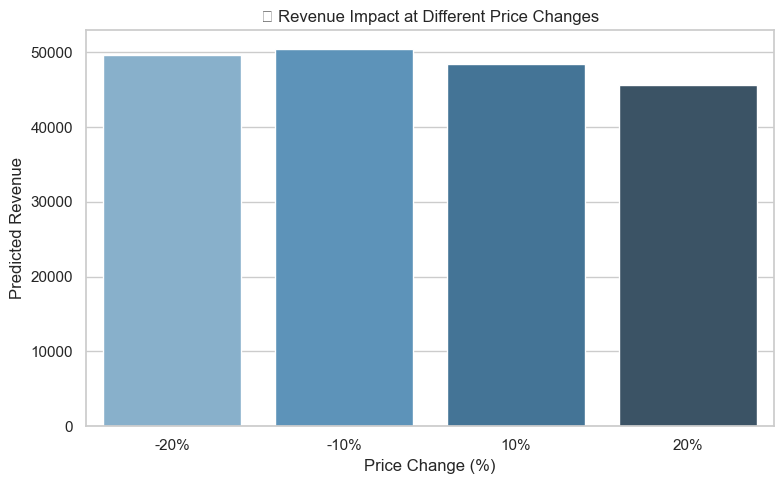

In [333]:
# Set Seaborn style
sns.set(style="whitegrid")

# Create a bar plot for revenue vs price change
plt.figure(figsize=(8, 5))
sns.barplot(data=sim_df, x='Price Change', y='Revenue', palette='Blues_d')

plt.title('💸 Revenue Impact at Different Price Changes')
plt.xlabel('Price Change (%)')
plt.ylabel('Predicted Revenue')
plt.tight_layout()
plt.show()

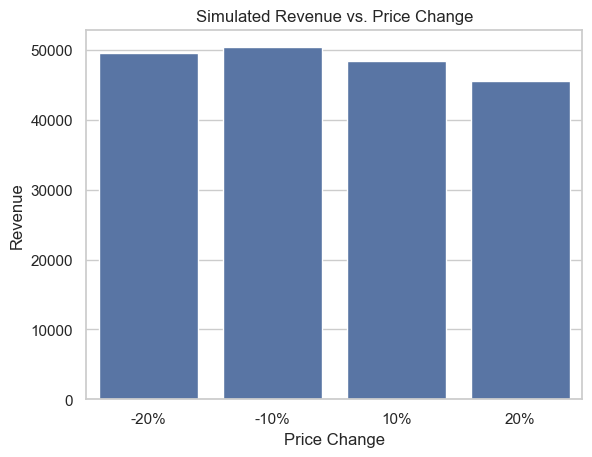

In [335]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='Price Change', y='Revenue', data=sim_df)
plt.title("Simulated Revenue vs. Price Change")
plt.show()

In [336]:
best_price = None
max_revenue = 0

for pct in np.arange(-0.5, 0.51, 0.01):
    new_price = base_price * (1 + pct)
    predicted_quantity = base_quantity * (1 + avg_elasticity * pct)
    revenue = new_price * predicted_quantity
    if revenue > max_revenue:
        max_revenue = revenue
        best_price = new_price

print(f"Optimal Price: {best_price}, Max Revenue: {max_revenue}")

Optimal Price: 92.00000000000004, Max Revenue: 50416.0


# Time series

In [328]:
######

In [339]:
data.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_timestamp,product_category_name,year,month,effective_price,month_sin,month_cos,lag_quantity,lag_price
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-13 08:59:02,cool_stuff,2017,9,72.19,-1.000000,-1.836970e-16,NaN,NaN
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04-26 10:53:06,pet_shop,2017,4,259.83,0.866025,-5.000000e-01,NaN,NaN
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:33:31,moveis_decoracao,2018,1,216.87,0.500000,8.660254e-01,NaN,NaN
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:00:35,perfumaria,2018,8,25.78,-0.866025,-5.000000e-01,NaN,NaN
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02-04 13:57:51,ferramentas_jardim,2017,2,218.04,0.866025,5.000000e-01,NaN,NaN


In [341]:
df.head()

,price,freight_value,product_category_name,year,month,effective_price,month_sin,month_cos,lag_quantity,lag_price,...,avg_price_per_seller,avg_freight_per_seller,category_price_rank,seller_freight_rank,product_price_std,product_avg_price,product_total_orders,seller_total_orders,total_quantity_sold,product_category_encoded
0,-0.169368,-0.368030,cool_stuff,-1.0,0.6,-0.195974,-0.732051,3.660254e-01,0.0,0.0,...,-0.134094,0.268901,0.880359,0.285583,0.020472,-0.164080,0.136364,-0.030733,-0.25,26
1,1.735895,0.454771,pet_shop,-1.0,-0.4,1.630783,0.633975,0.000000e+00,0.0,0.0,...,-0.353130,0.425024,-0.125163,0.414141,2.266980,1.724529,-0.227273,-0.068558,-0.25,63
2,1.305368,0.199504,moveis_decoracao,0.0,-1.0,1.212549,0.366025,1.000000e+00,0.0,0.0,...,1.827723,0.256806,-2.140066,0.270891,-0.233020,1.296979,-0.136364,-0.328605,0.00,54
3,-0.652632,-0.429988,perfumaria,0.0,0.4,-0.647796,-0.633975,-4.876438e-16,0.0,0.0,...,-0.330811,-0.054667,0.211309,-0.057851,-0.233020,-0.647487,-0.181818,-0.326241,0.00,62
4,1.314842,0.232962,ferramentas_jardim,-1.0,-0.8,1.223939,0.633975,7.320508e-01,0.0,0.0,...,0.442568,0.534737,-0.060625,0.497704,0.094541,1.332521,0.272727,-0.290780,-0.25,40


(112650, 25)

In [347]:
data['date'] = pd.to_datetime(data[['year', 'month']].assign(day=1))

In [349]:
data = data.sort_values('date')

In [351]:
print(data['effective_price'].dtype)

float64


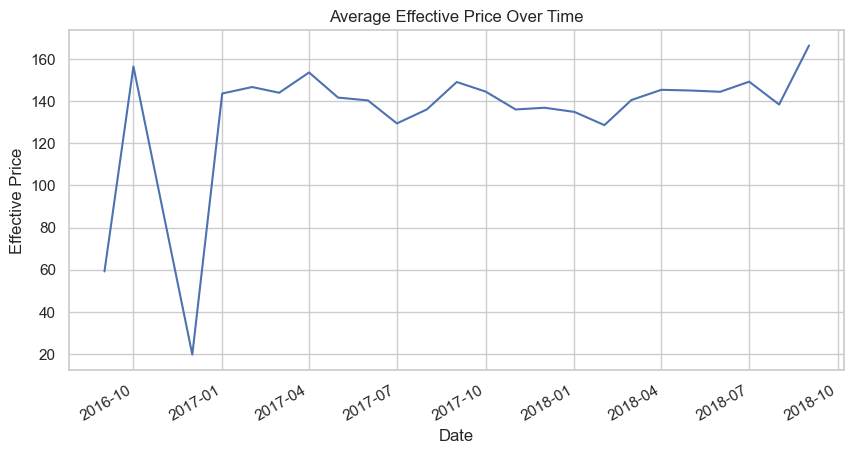

In [353]:
monthly_avg = data.groupby('date')['effective_price'].mean()

# Plotting
import matplotlib.pyplot as plt
monthly_avg.plot(figsize=(10,5), title='Average Effective Price Over Time')
plt.ylabel('Effective Price')
plt.xlabel('Date')
plt.grid(True)
plt.show()


In [355]:
data.set_index('date', inplace=True)

In [357]:
print(data.index)

DatetimeIndex(['2016-09-01', '2016-09-01', '2016-09-01', '2016-09-01',
               '2016-09-01', '2016-09-01', '2016-10-01', '2016-10-01',
               '2016-10-01', '2016-10-01',
               ...
               '2018-08-01', '2018-08-01', '2018-08-01', '2018-08-01',
               '2018-08-01', '2018-08-01', '2018-08-01', '2018-08-01',
               '2018-08-01', '2018-09-01'],
              dtype='datetime64[ns]', name='date', length=112650, freq=None)


In [359]:
print(data.head())

                                    order_id  order_item_id  \
date                                                          
2016-09-01  2e7a8482f6fb09756ca50c10d7bfc047              1   
2016-09-01  bfbd0f9bdef84302105ad712db648a6c              1   
2016-09-01  e5fa5a7210941f7d56d0208e4e071d35              1   
2016-09-01  bfbd0f9bdef84302105ad712db648a6c              2   
2016-09-01  bfbd0f9bdef84302105ad712db648a6c              3   

                                  product_id  \
date                                           
2016-09-01  c1488892604e4ba5cff5b4eb4d595400   
2016-09-01  5a6b04657a4c5ee34285d1e4619a96b4   
2016-09-01  f3c2d01a84c947b078e32bbef0718962   
2016-09-01  5a6b04657a4c5ee34285d1e4619a96b4   
2016-09-01  5a6b04657a4c5ee34285d1e4619a96b4   

                                   seller_id  shipping_limit_date  price  \
date                                                                       
2016-09-01  1554a68530182680ad5c8b042c3ab563  2016-10-26 18:25:19  39

date
2016-09-30     59.125000
2016-10-31    156.498182
2016-11-30           NaN
2016-12-31     19.620000
2017-01-31    143.652869
2017-02-28    146.735325
2017-03-31    144.016197
2017-04-30    153.659553
2017-05-31    141.728953
2017-06-30    140.374837
2017-07-31    129.447139
2017-08-31    136.090550
2017-09-30    149.120039
2017-10-31    144.553245
2017-11-30    136.081220
2017-12-31    136.897151
2018-01-31    134.905201
2018-02-28    128.637769
2018-03-31    140.577683
2018-04-30    145.416682
2018-05-31    145.082879
2018-06-30    144.486735
2018-07-31    149.284832
2018-08-31    138.425562
2018-09-30    166.460000
Freq: ME, Name: effective_price, dtype: float64


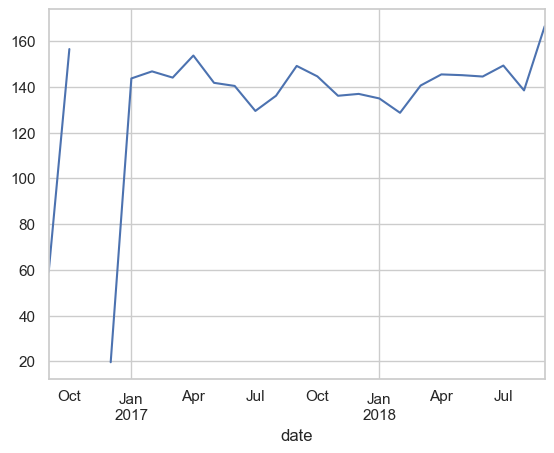

In [361]:
# Monthly average
monthly_avg = data['effective_price'].resample('M').mean()
print(monthly_avg)

# Plot
import matplotlib.pyplot as plt
monthly_avg.plot()
plt.show()

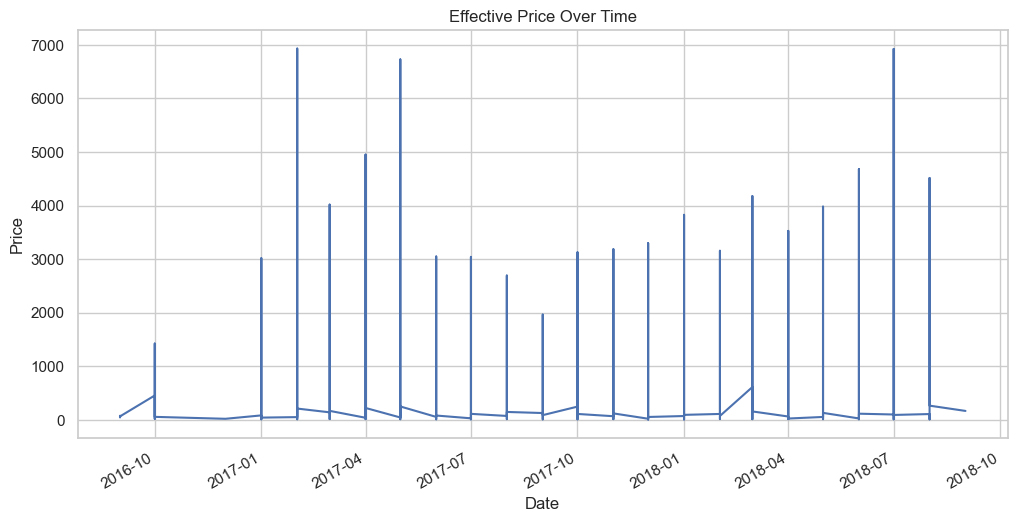

In [363]:
# 2. Plot a time-based trend (e.g., effective_price over time)

import matplotlib.pyplot as plt

data['effective_price'].plot(figsize=(12,6), title='Effective Price Over Time')
plt.ylabel('Price')
plt.xlabel('Date')
plt.grid(True)
plt.show()


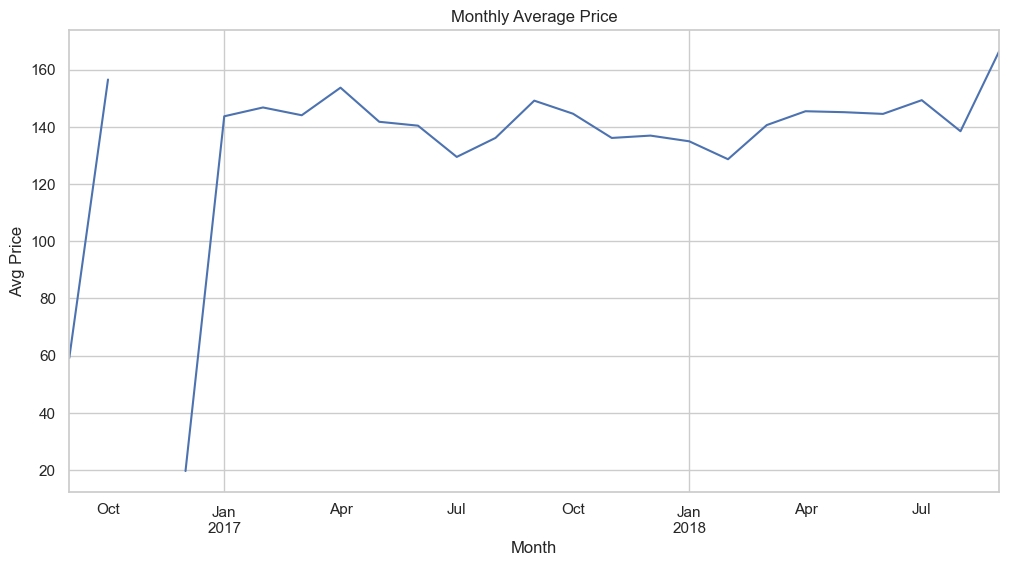

In [365]:
 #Resample monthly to remove noise

monthly_avg = data['effective_price'].resample('M').mean()

monthly_avg.plot(figsize=(12,6), title='Monthly Average Price')
plt.ylabel('Avg Price')
plt.xlabel('Month')
plt.grid(True)
plt.show()


model

In [367]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [371]:
data.index.to_series().diff().value_counts()

date
0 days     112626
31 days        13
30 days         7
28 days         2
61 days         1
Name: count, dtype: int64

In [379]:
print(data.index.dtype)

datetime64[ns]


In [381]:
data = data.index.sort_values('date')

In [390]:
print(type(data))

<class 'tuple'>


In [ ]:
######

In [394]:
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [450]:
data.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'year', 'month', 'effective_price',
       'month_sin', 'month_cos'],
      dtype='object')

In [452]:
# Convert to datetime
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'], errors='coerce')

# Set as index
data = data.set_index('order_purchase_timestamp')

# Sort by date
data = data.sort_index()

# Preview
print(data.head())

KeyError: 'order_purchase_timestamp'

order_purchase_timestamp
2016-09-04    2
2016-09-05    1
2016-09-06    0
2016-09-07    0
2016-09-08    0
Freq: D, dtype: int64


<Axes: title={'center': 'Daily Orders'}, xlabel='order_purchase_timestamp'>

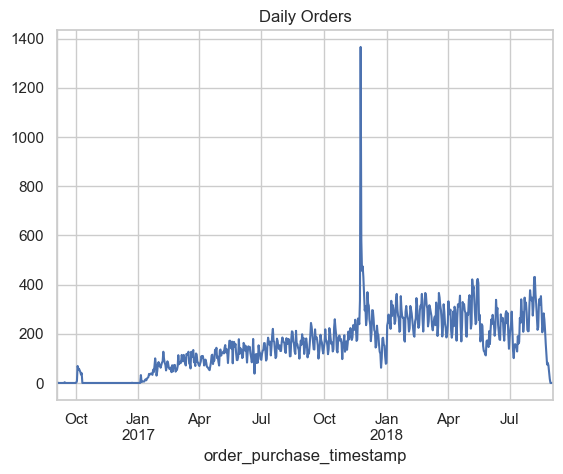

In [410]:
# For daily order count
daily_orders = data.resample('D').size()

# For daily revenue (if you have a 'price' column)
# daily_revenue = data['price'].resample('D').sum()

print(daily_orders.head())
daily_orders.plot(title='Daily Orders')

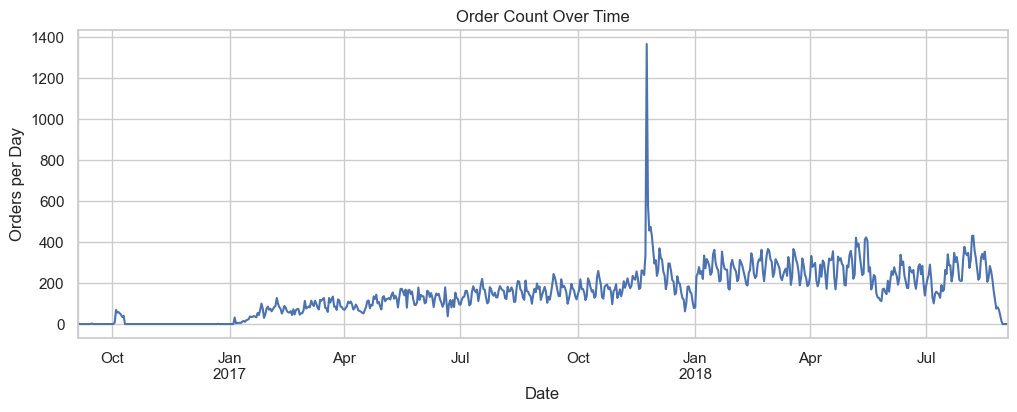

In [412]:
import matplotlib.pyplot as plt

daily_orders.plot(figsize=(12, 4), title='Order Count Over Time')
plt.ylabel("Orders per Day")
plt.xlabel("Date")
plt.grid(True)
plt.show()


In [414]:
# check frequency
print(data.index.to_series().diff().value_counts())

order_purchase_timestamp
0 days 00:00:00    14538
0 days 00:00:01      773
0 days 00:00:02      510
0 days 00:00:03      412
0 days 00:00:06      382
                   ...  
0 days 01:40:23        1
0 days 01:21:14        1
0 days 00:38:16        1
0 days 01:27:12        1
4 days 18:06:20        1
Name: count, Length: 4587, dtype: int64


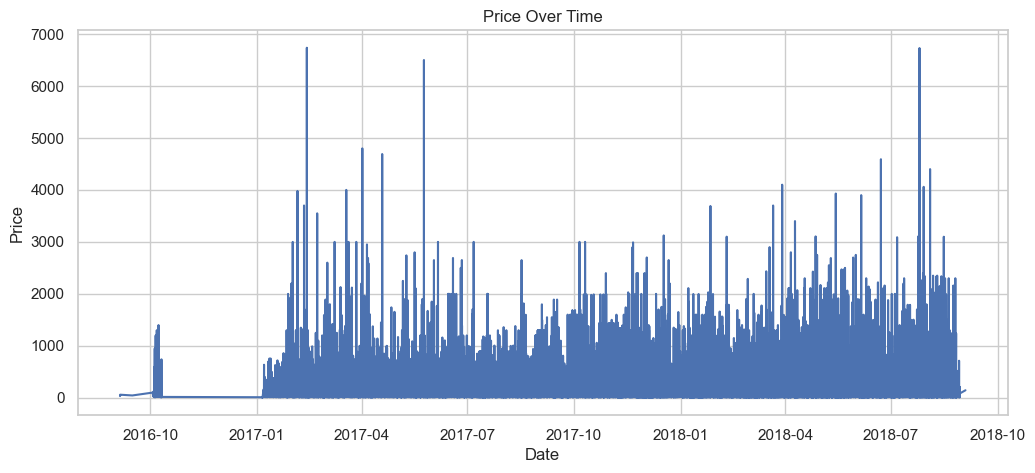

In [418]:
 #Step 4: Visualize the Time Series
#price over time
plt.figure(figsize=(12, 5))
plt.plot(data['price'])  # Replace 'price' with your actual column name
plt.title('Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

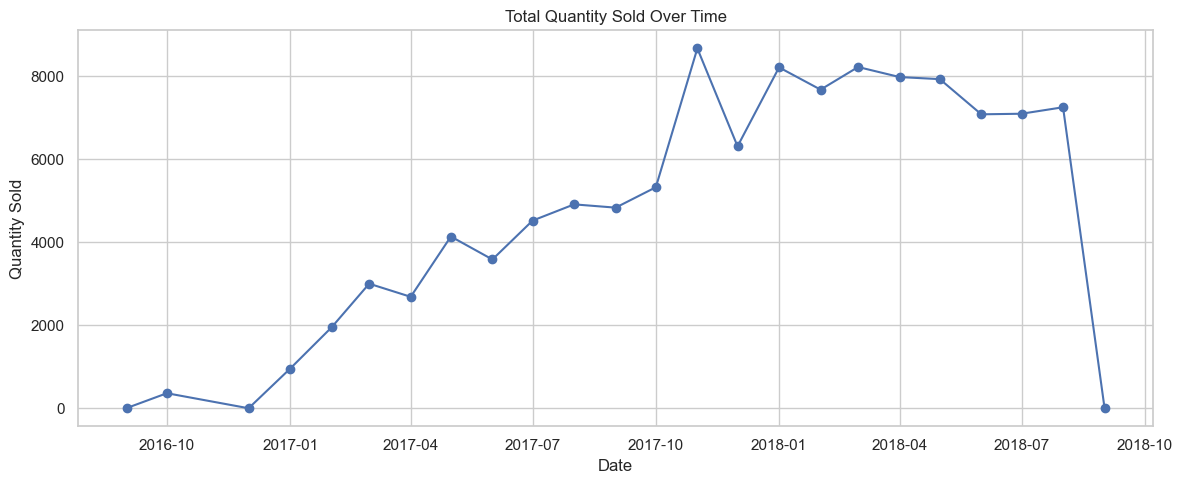

In [426]:
# Step 1: Create a new 'year-month' column
total_quantity_data['year_month'] = pd.to_datetime(
    total_quantity_data['year'].astype(str) + '-' + total_quantity_data['month'].astype(str)
)

# Step 2: Group by year_month and sum total quantity sold across all products
monthly_quantity = total_quantity_data.groupby('year_month')['total_quantity_sold_data'].sum().reset_index()

# Step 3: Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(monthly_quantity['year_month'], monthly_quantity['total_quantity_sold_data'], marker='o')
plt.title('Total Quantity Sold Over Time')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.grid(True)
plt.tight_layout()
plt.show()

In [444]:
data.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'year', 'month', 'effective_price',
       'month_sin', 'month_cos'],
      dtype='object')

In [428]:
#arima time series here

In [430]:
ts = total_quantity_data['total_quantity_sold_data']

In [432]:
model = ARIMA(ts, order=(1, 1, 1))  # (p, d, q)
model_fit = model.fit()
print(model_fit.summary())

                                  SARIMAX Results                                   
Dep. Variable:     total_quantity_sold_data   No. Observations:                62176
Model:                       ARIMA(1, 1, 1)   Log Likelihood             -138710.879
Date:                      Mon, 28 Jul 2025   AIC                         277427.759
Time:                              17:24:30   BIC                         277454.872
Sample:                                   0   HQIC                        277436.167
                                    - 62176                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5887      0.000   1535.832      0.000       0.588       0.589
ma.L1         -0.9999   6.48e-05  -1.54e+04      0.000      -1.000      -1.000
sigm

In [436]:
# Ensure your index is datetime
ts.index = pd.to_datetime(ts.index)

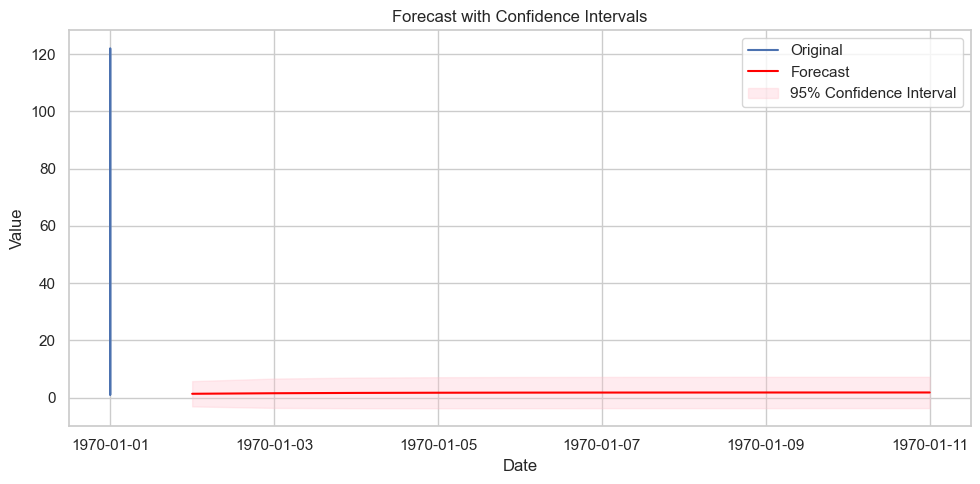

In [458]:
# Get forecast and confidence intervals
forecast_result = model_fit.get_forecast(steps=10)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Create future dates
future_dates = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=10, freq='D')

# Plot original data
plt.figure(figsize=(10, 5))
plt.plot(ts, label='Original')

# Plot forecast
plt.plot(future_dates, forecast, label='Forecast', color='red')

# Shade confidence interval
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\nandana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
C:\Users\nandana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
C:\Users\nandana\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


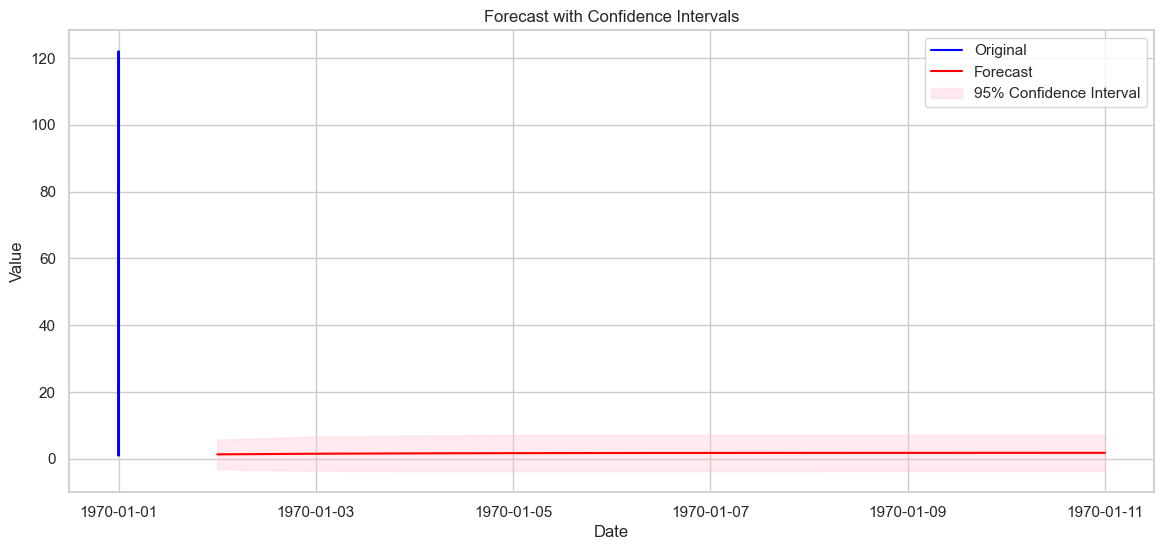

In [460]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# Ensure your original series has a datetime index
ts.index = pd.to_datetime(ts.index)

# Fit the model
model = ARIMA(ts, order=(1, 1, 1))
model_fit = model.fit()

# Forecast with confidence intervals
forecast_result = model_fit.get_forecast(steps=10)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Create future dates
future_dates = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=10)

# Set correct index to forecast and conf_int
forecast.index = future_dates
conf_int.index = future_dates

# Plot original data
plt.figure(figsize=(14,6))
plt.plot(ts, label='Original', color='blue')

# Plot forecast
plt.plot(forecast, label='Forecast', color='red')

# Plot confidence intervals
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
